=== INTEGRATION CHECKS ===
{'missing_columns': [], 'unexpected_columns': [], 'null_counts': {'feat_1': 0, 'feat_2': 0, 'feat_3': 0, 'target': 0}} 

=== MODEL METRICS ===
{'accuracy': 0.85, 'auc': 0.943} 

=== FEATURE COEFFICIENTS (descending by |weight|) ===
{'feat_1': 2.1293614917590795, 'feat_2': -1.5631633677404209, 'feat_3': 1.16213533174778} 



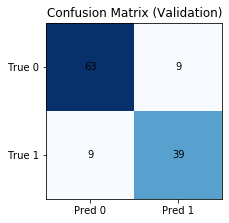

=== INTEGRATION DRIFT CHECK (Val vs Train) ===
{'features': ['feat_1', 'feat_2', 'feat_3'], 'delta_mean_z': [0.044, 0.116, 0.094], 'delta_std_rel': [0.027, 0.057, 0.012]} 



In [2]:
# Name: AI & ML Integration
# Author: Rod Villalobos
# Purpose: Show an AI prototype performing AI & ML Integration


import os, math, json, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# --- (Optional) Load your data instead of synthetic ---
CSV_PATH = None  # e.g., "my_data.csv" with columns: features..., target
TARGET = "target"

# --- 1) Data creation / loading ---
np.random.seed(11)
if CSV_PATH and os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    assert TARGET in df.columns, f"CSV must contain a '{TARGET}' column."
else:
    # Synthetic binary classification (linearly separable-ish)
    N = 600
    x1 = np.random.normal(0, 1, N)
    x2 = np.random.normal(0, 1, N)
    x3 = np.random.normal(0, 1, N)
    logits = 1.2*x1 - 0.8*x2 + 0.5*x3 + np.random.normal(0, 0.8, N)
    y = (logits > 0.3).astype(int)
    df = pd.DataFrame({"feat_1": x1, "feat_2": x2, "feat_3": x3, TARGET: y})

# --- 2) Minimal schema + null checks (integration sanity) ---
expected_cols = [c for c in df.columns if c != TARGET] + [TARGET]
missing = [c for c in expected_cols if c not in df.columns]
unexpected = [c for c in df.columns if c not in expected_cols]
null_counts = df.isna().sum().to_dict()

print("=== INTEGRATION CHECKS ===")
print({"missing_columns": missing, "unexpected_columns": unexpected, "null_counts": null_counts}, "\n")

# Simple fill for any nulls (just to keep demo flowing)
for c in df.columns:
    if df[c].isna().any():
        if df[c].dtype.kind in "fc":  # float-like
            df[c] = df[c].fillna(df[c].median())
        else:
            df[c] = df[c].fillna(df[c].mode().iloc[0])

# --- 3) Train/validation split ---
from_idx = 0
feat_cols = [c for c in df.columns if c != TARGET]
X = df[feat_cols].values.astype(float)
y = df[TARGET].values.astype(int)

# Shuffle indices
idx = np.arange(len(df))
np.random.shuffle(idx)
split = int(0.8 * len(df))
train_idx, val_idx = idx[:split], idx[split:]

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val     = X[val_idx], y[val_idx]

# Standardize (fit on train, apply to val)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0) + 1e-8
X_train_std = (X_train - mu) / sigma
X_val_std   = (X_val   - mu) / sigma

# --- 4) Try sklearn; otherwise NumPy logistic regression fallback ---
use_sklearn = False
try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
    clf = LogisticRegression(max_iter=200, solver="lbfgs")
    clf.fit(X_train_std, y_train)
    use_sklearn = True
except Exception as e:
    # Minimal NumPy logistic regression (GD) fallback
    def sigmoid(z): return 1/(1+np.exp(-z))
    def train_logreg(X, y, lr=0.1, iters=500):
        w = np.zeros(X.shape[1]); b = 0.0
        for _ in range(iters):
            z = X.dot(w) + b
            p = sigmoid(z)
            grad_w = X.T.dot(p - y)/len(y)
            grad_b = (p - y).mean()
            w -= lr*grad_w; b -= lr*grad_b
        return w, b
    w, b = train_logreg(X_train_std, y_train)

# --- 5) Predictions & Metrics ---
if use_sklearn:
    prob_val = clf.predict_proba(X_val_std)[:, 1]
    pred_val = (prob_val >= 0.5).astype(int)
    acc = float((pred_val == y_val).mean())
    try:
        auc = float(roc_auc_score(y_val, prob_val))
    except Exception:
        auc = None
else:
    prob_val = 1/(1+np.exp(-(X_val_std.dot(w) + b)))
    pred_val = (prob_val >= 0.5).astype(int)
    acc = float((pred_val == y_val).mean())
    auc = None  # AUC needs sklearn or manual implementation

print("=== MODEL METRICS ===")
print({"accuracy": round(acc, 3), "auc": (round(auc,3) if auc is not None else None)}, "\n")

# --- 6) Feature coefficients / importance (quick view) ---
if use_sklearn:
    coefs = clf.coef_.ravel()
else:
    coefs = w

coef_view = {feat_cols[i]: float(coefs[i]) for i in range(len(feat_cols))}
coef_view = dict(sorted(coef_view.items(), key=lambda kv: abs(kv[1]), reverse=True))
print("=== FEATURE COEFFICIENTS (descending by |weight|) ===")
print(coef_view, "\n")

# --- 7) Confusion matrix (sklearn only) ---
if use_sklearn:
    cm = confusion_matrix(y_val, pred_val)
    plt.figure(figsize=(3.6,3.2))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix (Validation)")
    plt.xticks([0,1], ["Pred 0","Pred 1"])
    plt.yticks([0,1], ["True 0","True 1"])
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.show()

# --- 8) Simple drift-ish check (compare val vs train means/stds) ---
train_stats = {"mean": mu.tolist(), "std": sigma.tolist()}
val_mu, val_sigma = X_val.mean(axis=0), X_val.std(axis=0) + 1e-8
delta_mean = np.abs((val_mu - mu) / (sigma + 1e-8))
delta_std  = np.abs((val_sigma - sigma) / (sigma + 1e-8))

drift_summary = {
    "features": feat_cols,
    "delta_mean_z": [round(x,3) for x in delta_mean.tolist()],
    "delta_std_rel": [round(x,3) for x in delta_std.tolist()]
}
print("=== INTEGRATION DRIFT CHECK (Val vs Train) ===")
print(drift_summary, "\n")

